In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [2]:
scaler = StandardScaler()

# EDA

Setiap file csv, itu adalah data rekaman real-time Tegangan, Arus, Temperatur, Beban Arus, & Beban Tegangan baterai saat pengosongan (discharge)

In [3]:
testing_record = pd.read_csv('data/00001.csv')
testing_record.head()

,Voltage_measured,Current_measured,Temperature_measured,Current_load,Voltage_load,Time
0,4.246711,0.000252,6.212696,0.0002,0.000,0.000
1,4.246764,-0.001411,6.234019,0.0002,4.262,9.360
2,4.039277,-0.995093,6.250255,1.0000,3.465,23.281
3,4.019506,-0.996731,6.302176,1.0000,3.451,36.406
4,4.004763,-0.992845,6.361645,1.0000,3.438,49.625


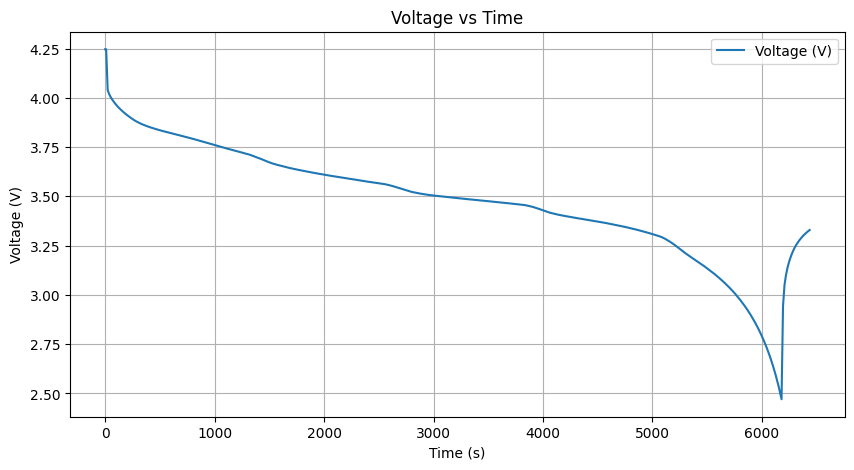

In [4]:
plt.figure(figsize=(10, 5))
plt.plot(testing_record['Time'],testing_record['Voltage_measured'], label='Voltage (V)')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.title('Voltage vs Time')
plt.grid()
plt.show()

Tegangan baterai semakin menurun seiring waktu

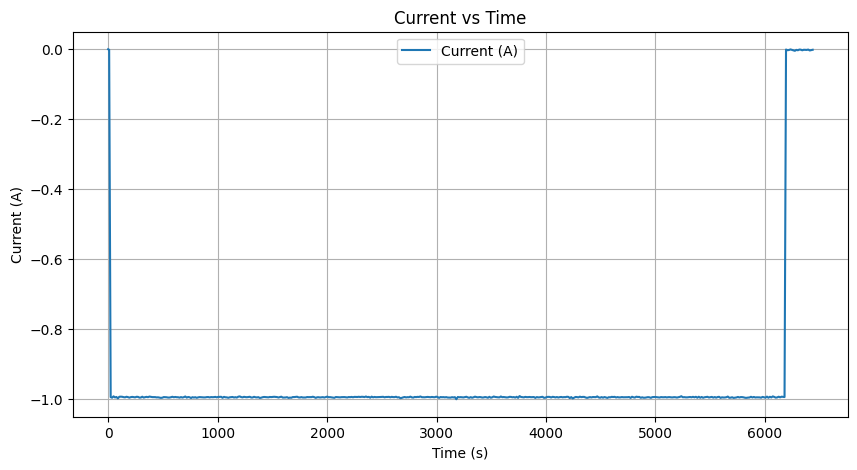

In [5]:
plt.figure(figsize=(10, 5))
plt.plot(testing_record['Time'], testing_record['Current_measured'], label='Current (A)')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Current (A)')
plt.title('Current vs Time')
plt.grid()
plt.show()

Arus cenderung konstan seiring waktu

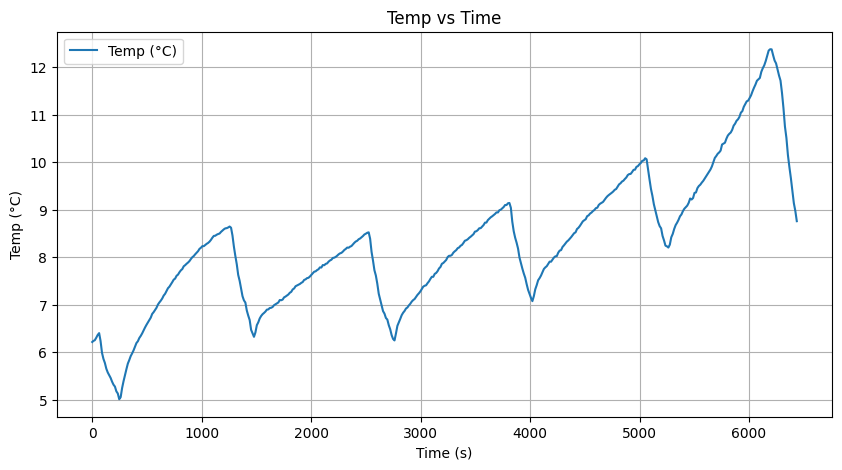

In [6]:
plt.figure(figsize=(10, 5))
plt.plot(testing_record['Time'], testing_record['Temperature_measured'], label='Temp (°C)')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Temp (°C)')
plt.title('Temp vs Time')
plt.grid()
plt.show()

Seiring waktu, temperatur baterai semakin panas

metadata.csv berisi detail / informasi deskriptif dari setiap data uji coba baterai yang ada pada folder 'data'

In [7]:
metadata = pd.read_csv('metadata.csv')

metadata.head()

,type,start_time,ambient_temperature,battery_id,test_id,uid,filename,Capacity,Re,Rct
0,discharge,[2010. 7. 21. 15. 0. ...,4,B0047,0,1,00001.csv,1.6743047446975208,NaN,NaN
1,impedance,[2010. 7. 21. 16. 53. ...,24,B0047,1,2,00002.csv,NaN,0.05605783343888099,0.20097016584458333
2,charge,[2010. 7. 21. 17. 25. ...,4,B0047,2,3,00003.csv,NaN,NaN,NaN
3,impedance,[2010 7 21 20 31 5],24,B0047,3,4,00004.csv,NaN,0.05319185850921101,0.16473399914864734
4,discharge,[2.0100e+03 7.0000e+00 2.1000e+01 2.1000e+01 2...,4,B0047,4,5,00005.csv,1.5243662105099023,NaN,NaN


Melalui metadata kita bisa mengetahui percobaan mana yang tipe nya discharge (pengosongan baterai) melalui kolom battery_id

In [8]:
metadata[metadata['type'] == 'discharge']['battery_id']

0       B0047
4       B0047
6       B0047
8       B0047
10      B0047
        ...  
7553    B0055
7555    B0055
7557    B0055
7561    B0055
7563    B0055
Name: battery_id, Length: 2794, dtype: object

# Data Preprocessing

Hanya menggunakan data percobaan discharge

In [9]:
excluded_batteries = ['B0049', 'B0050', 'B0051', 'B0052']


discharged_metadata = metadata[ (metadata['type'] == 'discharge')]
# discharged_metadata = metadata[ (metadata['type'] == 'discharge') & (~metadata['battery_id'].isin(excluded_batteries))]

In [10]:
discharged_metadata['battery_id'].unique()

array(['B0047', 'B0045', 'B0048', 'B0046', 'B0043', 'B0032', 'B0039',
       'B0040', 'B0029', 'B0028', 'B0042', 'B0034', 'B0038', 'B0033',
       'B0030', 'B0041', 'B0027', 'B0044', 'B0036', 'B0025', 'B0026',
       'B0031', 'B0049', 'B0050', 'B0052', 'B0051', 'B0006', 'B0005',
       'B0007', 'B0018', 'B0053', 'B0054', 'B0056', 'B0055'], dtype=object)

Tiap battery_id beda kasih cycle number berurut

In [11]:
discharged_metadata.loc[:, 'cycle_number'] = discharged_metadata.groupby('battery_id').cumcount() + 1

C:\Users\Asus TUF\AppData\Local\Temp\ipykernel_33964\1309199493.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  discharged_metadata.loc[:, 'cycle_number'] = discharged_metadata.groupby('battery_id').cumcount() + 1


In [12]:
discharged_metadata.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2794 entries, 0 to 7563
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   type                 2794 non-null   object
 1   start_time           2794 non-null   object
 2   ambient_temperature  2794 non-null   int64 
 3   battery_id           2794 non-null   object
 4   test_id              2794 non-null   int64 
 5   uid                  2794 non-null   int64 
 6   filename             2794 non-null   object
 7   Capacity             2794 non-null   object
 8   Re                   0 non-null      object
 9   Rct                  0 non-null      object
 10  cycle_number         2794 non-null   int64 
dtypes: int64(4), object(7)
memory usage: 261.9+ KB


In [13]:
# ambil semua capacities dari discharged_metadata dan ubah ke bentuk numeric
initial_capacities = pd.to_numeric(discharged_metadata['Capacity'], errors='coerce')
initial_capacities.max()

2.6401491157387014

In [14]:
nominal_capacity = initial_capacities.mean()

nominal_capacity = 2.0

print(nominal_capacity)

2.0


In [15]:
# A battery is considered unfit for use when its SoH reaches 80%
degrade_capacity_threshold = nominal_capacity * 80/100 
print(degrade_capacity_threshold)

1.6


- Pada step selanjutnya akan dilakukan trimming pada data rekaman yang Voltagenya dibawah 2.7 V karena dibwh 2.7 V berarti baterai ud mw habis. Kita hanya analisis data rekaman baterai sebelum dia habis. Ini dilakukan untuk semua file csv yang tipe experimennya discharge.

- Setelah mendapatkan data rekaman diatas 2.7 V, kita menghitung Capacity baterai menggunakan rumus.

- Melalui Capacity kita bisa menghitung SoC , melalui SoC kita bisa menghitung SoH.

- Masing-masing perhitungan dibuatkan kolom terpisah dalam current dataframe yang diiterasi.



In [16]:
processed_dfs = []

In [17]:
for _, row in tqdm(discharged_metadata.iterrows(), total=len(discharged_metadata)):
    
    try:
        file = f"data/{row.filename}"
        df = pd.read_csv(file)

        # cari idx saat voltage pertama kali dibwh 2.7 V, karena dibwh 2.7 V berarti baterai ud mw habis
        cutoff_idx = df[df['Voltage_measured'] < 2.7].index.min()
        # ambil data saat >= 2.7 V saja 
        cutoff_df = df if pd.isna(cutoff_idx) else df.iloc[:cutoff_idx].copy()
        # hitung time diff dalam jam
        cutoff_df['Time_diff_hr'] = cutoff_df['Time'].diff().fillna(0) / 3600
        # hitung Delta Q -> Current Measured x Timediff hr
        cutoff_df['Delta_q'] = cutoff_df['Current_measured'] * cutoff_df['Time_diff_hr']
        #hitung capacity total dari current df (Ah)
        total_capacity = abs(cutoff_df['Delta_q'].sum())
        

        # I understand it now
        #  asumsi 2.0 capacity awal or no? soalnya saat dihitung rata-ratanya capacity awalnya ternyata itu 1.3..
        # Kita ambil data dengan kapasitas di atas threshold supaya hanya menganalisis siklus baterai yang masih sehat atau layak.
        # Kalau kapasitas sudah di bawah threshold, berarti baterai sudah terlalu rusak/degradasi berat, dan data itu kurang representatif untuk analisis kesehatan normal baterai.
        if total_capacity > degrade_capacity_threshold:

            cutoff_df['battery_id'] = row.battery_id
            cutoff_df['cycle_number'] = row.cycle_number
            
            cutoff_df['cumulative_q'] = cutoff_df['Delta_q'].cumsum()
            cutoff_df['SoC'] = 100 * (1 + (cutoff_df['cumulative_q'] / total_capacity))

            if cutoff_df['SoC'].min() < 0 or cutoff_df['SoC'].max() > 100:
                continue
            else :
            # if True:


                soh = (total_capacity / nominal_capacity) * 100

                if soh > 100:
                    continue

                else:
                    cutoff_df['SoH'] = soh 
                    # cutoff_df['SoH'] = min(soh, 100)
                    num_bins = 20
                    #downsampling membagi data jadi num_bins group, tiap group rata-rata isinya len(cutoff_df) / num_bins
                    #downsampling buat efesiensi komputasi 
                    bins = np.array_split(cutoff_df, num_bins)
                    # print(len())
                    agg_rows = []
                    for b in bins:
                        
                        if b.empty:
                            continue 

                        avg_voltage = b['Voltage_measured'].mean()
                        avg_current = b['Current_measured'].mean()
                        avg_temp = b['Temperature_measured'].mean()
                        avg_soc = b['SoC'].mean()                


                        agg_rows.append({
                            'Voltage_measured': avg_voltage,
                            'Current_measured': avg_current,
                            'Temperature_measured': avg_temp,
                            'SoC': avg_soc,
                            'cycle_number': b['cycle_number'].iloc[0],
                            'battery_id': b['battery_id'].iloc[0],
                            'SoH': b['SoH'].iloc[0]
                        })

                        
                    downsampled_df = pd.DataFrame(agg_rows)

                    if len(downsampled_df) != num_bins:
                        continue
                    
                    processed_dfs.append(downsampled_df)

    except Exception as e:
        print(f"Error processing {row['filename']}: {str(e)}")

            # print(downsampled_df)

       


  4%|▍         | 117/2794 [00:00<00:09, 284.32it/s]C:\Users\Asus TUF\AppData\Roaming\Python\Python312\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
  7%|▋         | 193/2794 [00:00<00:07, 339.19it/s]C:\Users\Asus TUF\AppData\Roaming\Python\Python312\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
 10%|▉         | 275/2794 [00:00<00:06, 378.65it/s]C:\Users\Asus TUF\AppData\Roaming\Python\Python312\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Asus TUF\AppData\Roaming\Python\Python312\site-packages\numpy\co

In [18]:
full_dataset = []

In [19]:
# Combine all processed data
if processed_dfs:
    full_dataset = pd.concat(processed_dfs)
    print(f"Final dataset shape: {full_dataset.shape}")
    full_dataset.to_csv("battery_health_dataset.csv", index=False)
else:
    print("No valid files found!")

Final dataset shape: (7580, 7)


In [20]:
full_dataset.head()

,Voltage_measured,Current_measured,Temperature_measured,SoC,cycle_number,battery_id,SoH
0,3.933872,-0.910240,5.709549,97.782376,1,B0048,82.812306
1,3.809721,-0.996627,6.401722,92.753496,1,B0048,82.812306
2,3.764703,-0.996853,7.550120,87.718658,1,B0048,82.812306
3,3.719869,-0.996684,8.180165,82.684750,1,B0048,82.812306
4,3.672564,-0.996490,7.078115,77.649810,1,B0048,82.812306


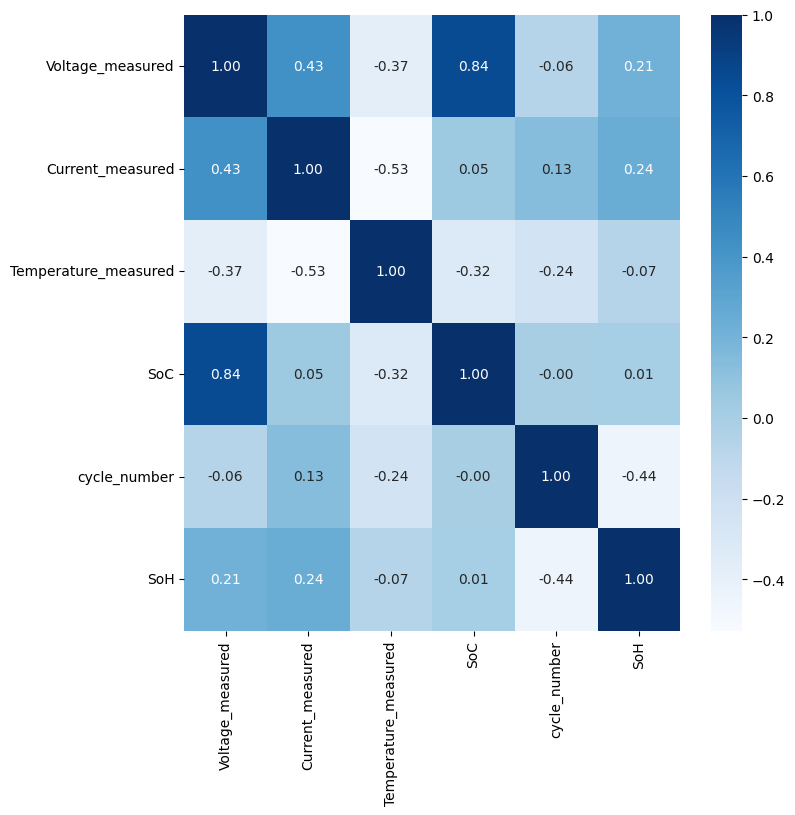

In [21]:
corr = full_dataset.corr(numeric_only=True)
plt.figure(figsize=(8,8))
sb.heatmap(annot=True, data = corr, fmt='.2f', cmap='Blues')
plt.show()


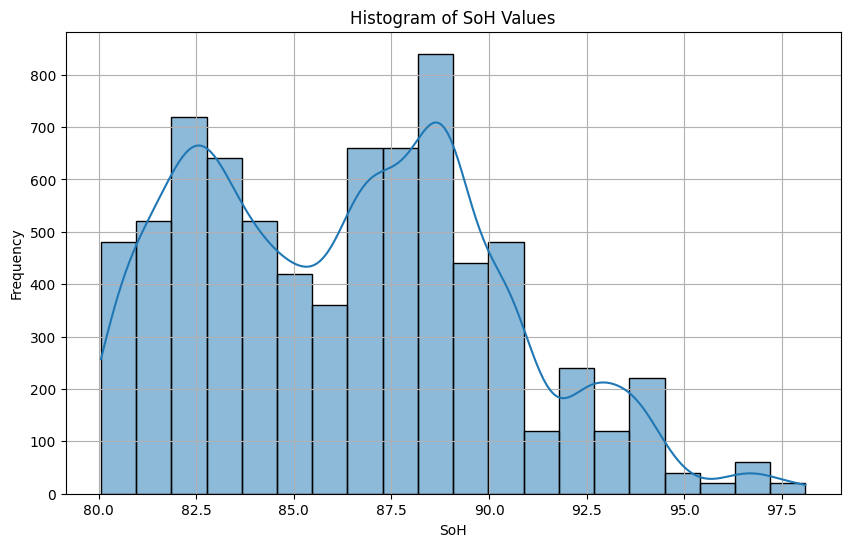

In [22]:

plt.figure(figsize=(10, 6))
sb.histplot(full_dataset['SoH'], bins=20, kde=True)
plt.title('Histogram of SoH Values')
plt.xlabel('SoH')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [23]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split



X = full_dataset[[
    'Voltage_measured', 
    'Current_measured', 
    'Temperature_measured',
    'SoC', 
    'cycle_number'
]]
y = full_dataset['SoH']



# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)



# Train the model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

C:\Users\Asus TUF\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


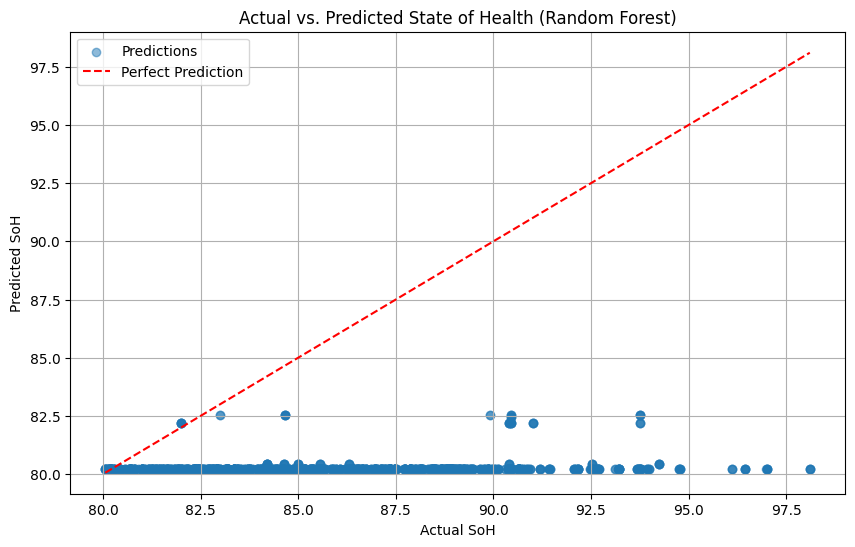

Random Forest Results:
Mean Absolute Error (MAE): 5.90
Root Mean Squared Error (RMSE): 7.02
R² Score: -2.36


In [34]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# Visualize predictions
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, label='Predictions')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 
         color='red', linestyle='--', label='Perfect Prediction')
plt.xlabel('Actual SoH')
plt.ylabel('Predicted SoH')
plt.title('Actual vs. Predicted State of Health (Random Forest)')
plt.legend()
plt.grid(True)
plt.show()

# Print metrics
# print(y_test)
# print(y_pred)
print(f"Random Forest Results:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

In [25]:
from sklearn.model_selection import GridSearchCV

param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5]
}

rf = RandomForestRegressor(random_state=42)
grid_rf = GridSearchCV(rf, param_grid_rf, cv=5, n_jobs=-1, verbose=1)
grid_rf.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [10, 20], 'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]},
             verbose=1)

0.854185785361352


C:\Users\Asus TUF\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


In [26]:
# Train and evaluate XGBoost model
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

# Prepare features and target
X = full_dataset[[
    'Voltage_measured', 
    'Current_measured', 
    'Temperature_measured',
    'SoC', 
    'cycle_number'
]]
y = full_dataset['SoH']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train the XGBoost model
xgb_model = XGBRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

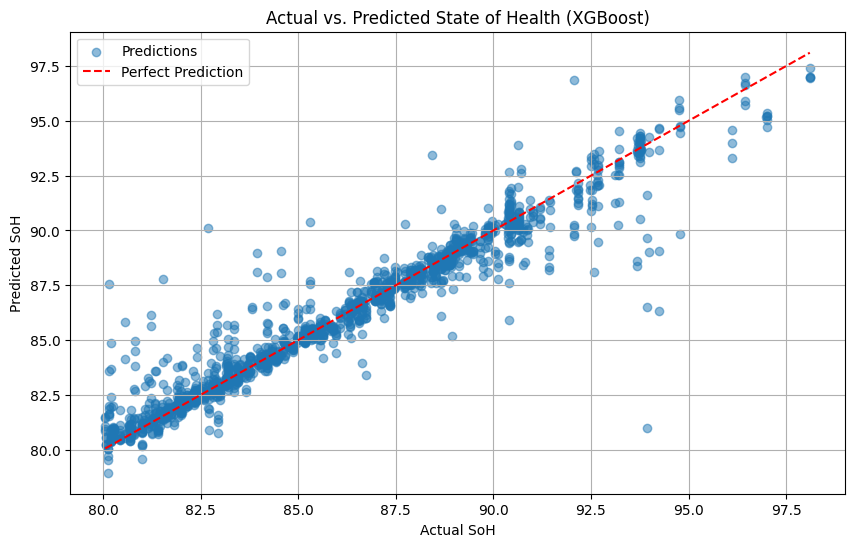

XGBoost Results:
Mean Absolute Error (MAE): 0.56
Root Mean Squared Error (RMSE): 1.06
R² Score: 0.92


In [27]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Predict on the test set
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate the model
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)

# Visualize predictions
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_xgb, alpha=0.5, label='Predictions')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 
         color='red', linestyle='--', label='Perfect Prediction')
plt.xlabel('Actual SoH')
plt.ylabel('Predicted SoH')
plt.title('Actual vs. Predicted State of Health (XGBoost)')
plt.legend()
plt.grid(True)
plt.show()

# Print metrics
# print(y_test)
# print(y_pred)
print(f"XGBoost Results:")
print(f"Mean Absolute Error (MAE): {mae_xgb:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_xgb:.2f}")
print(f"R² Score: {r2_xgb:.2f}")

In [28]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler



# Prepare features and target
X = full_dataset[[
    'Voltage_measured', 
    'Current_measured', 
    'Temperature_measured',
    'SoC', 
    'cycle_number'
]]
y = full_dataset['SoH']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


model_svm = svm.SVR() 
model_svm.fit(X_train, y_train)





SVR()

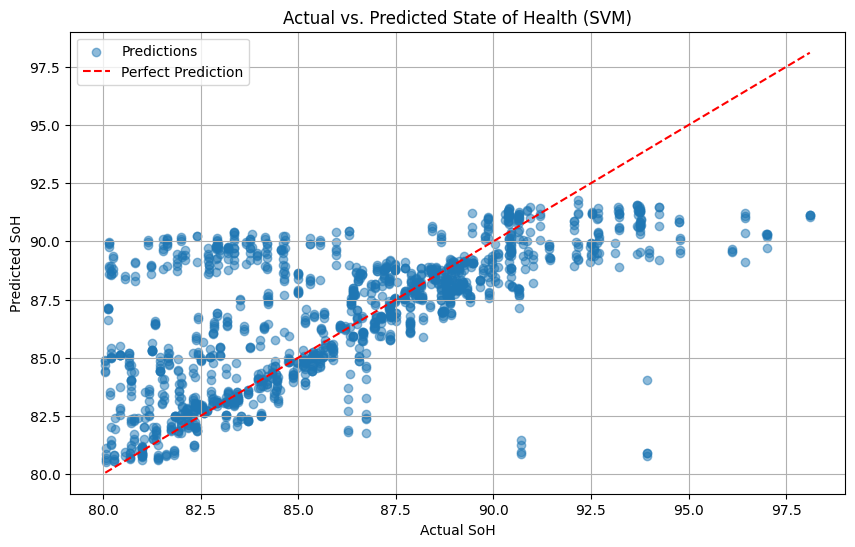

SVM Results:
Mean Absolute Error (MAE): 1.95
Root Mean Squared Error (RMSE): 2.96
R² Score: 0.40


In [29]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Predict on the test set
y_pred_svm = model_svm.predict(X_test)

# Evaluate the model
mae_svm = mean_absolute_error(y_test, y_pred_svm)
rmse_svm = np.sqrt(mean_squared_error(y_test, y_pred_svm))
r2_svm = r2_score(y_test, y_pred_svm)

# Visualize predictions
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_svm, alpha=0.5, label='Predictions')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 
         color='red', linestyle='--', label='Perfect Prediction')
plt.xlabel('Actual SoH')
plt.ylabel('Predicted SoH')
plt.title('Actual vs. Predicted State of Health (SVM)')
plt.legend()
plt.grid(True)
plt.show()

# Print metrics
# print(y_test)
# print(y_pred)
print(f"SVM Results:")
print(f"Mean Absolute Error (MAE): {mae_svm:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_svm:.2f}")
print(f"R² Score: {r2_svm:.2f}")

Fitting 5 folds for each of 60 candidates, totalling 300 fits


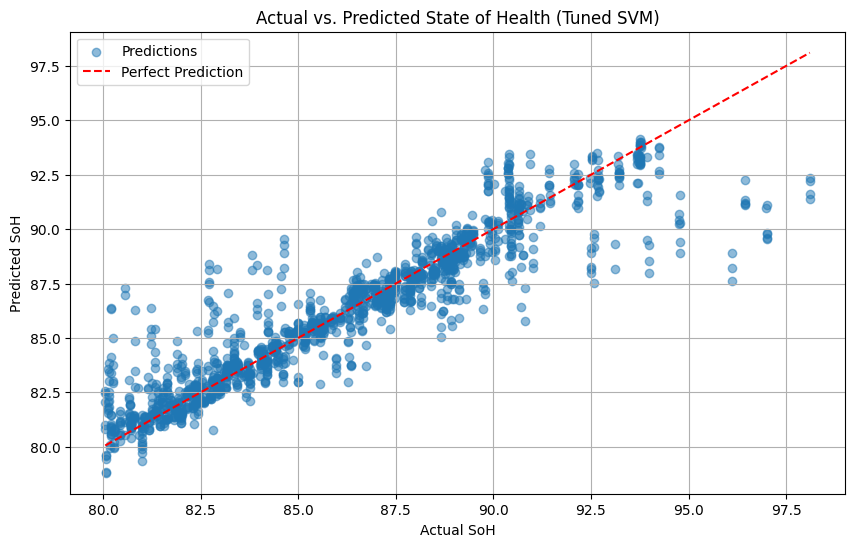

Tuned Support Vector Machine Results:
Best Parameters: {'C': 100, 'epsilon': 0.5, 'gamma': 1}
Mean Absolute Error (MAE): 0.88
Root Mean Squared Error (RMSE): 1.46
R² Score: 0.85


In [33]:
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# Prepare features and target
X = full_dataset[[ 
    'Voltage_measured', 
    'Current_measured', 
    'Temperature_measured', 
    'SoC', 
    'cycle_number'
]]
y = full_dataset['SoH']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Set up SVR and GridSearchCV
param_grid = {
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.01, 0.1, 0.5],
    'gamma': ['scale', 'auto', 0.01, 0.1, 1]
}

svr = SVR(kernel='rbf')
grid_search = GridSearchCV(svr, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
grid_search.fit(X_train_scaled, y_train)

# Best model
best_model = grid_search.best_estimator_

# Predict
y_pred = best_model.predict(X_test_scaled)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# Visualize
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, label='Predictions')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 
         color='red', linestyle='--', label='Perfect Prediction')
plt.xlabel('Actual SoH')
plt.ylabel('Predicted SoH')
plt.title('Actual vs. Predicted State of Health (Tuned SVM)')
plt.legend()
plt.grid(True)
plt.show()

# Print metrics
print(f"Tuned Support Vector Machine Results:")
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.2f}")